In [29]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
import math
from matplotlib import style
style.use('dark_background')
style.use('bmh')

In [30]:
def init(qubits, value, qc):
    n = len(qubits)
    for i in range(n):
        if value[i]=='1':
            qc.x(qubits[i])
#     qc.barrier()
    return qc

In [31]:
def makeQFT_Try(qc):
    n = qc.num_qubits
    for i in range(n):
        qc.h(i)
        for j in range(1, n-i):
            qc.cu1(np.pi/math.pow(2, j), i, i+j)
        qc.barrier()    
    return qc

In [46]:
def makeQFT(qc):
    n = qc.num_qubits
    for i in range(n-1, -1, -1):
        qc.h(i)
        for j in range(i):
            qc.cu1(np.pi/math.pow(2, i-j), i, j)
    for i in range(n//2):
        qc.swap(i, n-i-1)
#     display(qc.draw())
    return qc

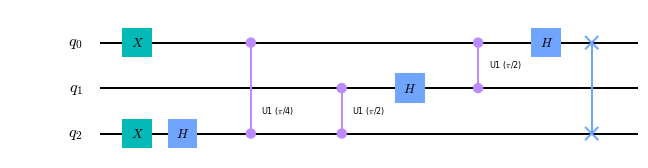

[ 3.53553391e-01-8.65956056e-17j -2.50000000e-01-2.50000000e-01j
  1.08244507e-16+3.53553391e-01j  2.50000000e-01-2.50000000e-01j
 -3.53553391e-01+8.65956056e-17j  2.50000000e-01+2.50000000e-01j
 -1.08244507e-16-3.53553391e-01j -2.50000000e-01+2.50000000e-01j]


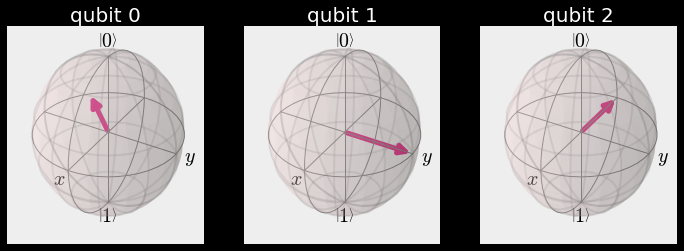

In [47]:
n = 3
qc = QuantumCircuit(n)
qc = init([2,1,0], '101', qc)

qc = makeQFT(qc)
# qc.append(qiskit.circuit.library.QFT(n), range(n))


display(qc.draw('mpl'))
sim = Aer.get_backend('statevector_simulator')
result = execute(qc, sim, shots = 1).result()
# plot_histogram(result.get_counts(qc))
print(result.get_statevector())
display(plot_bloch_multivector(result.get_statevector()))


# n = 4
# qc2 = QuantumCircuit(n)
# qc2 = init('0010', qc2)
# qc2 = makeQFT_Try(qc2)
# # for i in range(n):
# #     qc.measure(i, i)

# display(qc2.draw('mpl'))
# # sim = Aer.get_backend('statevector_simulator')
# result = execute(qc2, sim, shots = 1).result()
# # plot_histogram(result.get_counts(qc))
# display(plot_bloch_multivector(result.get_statevector()))

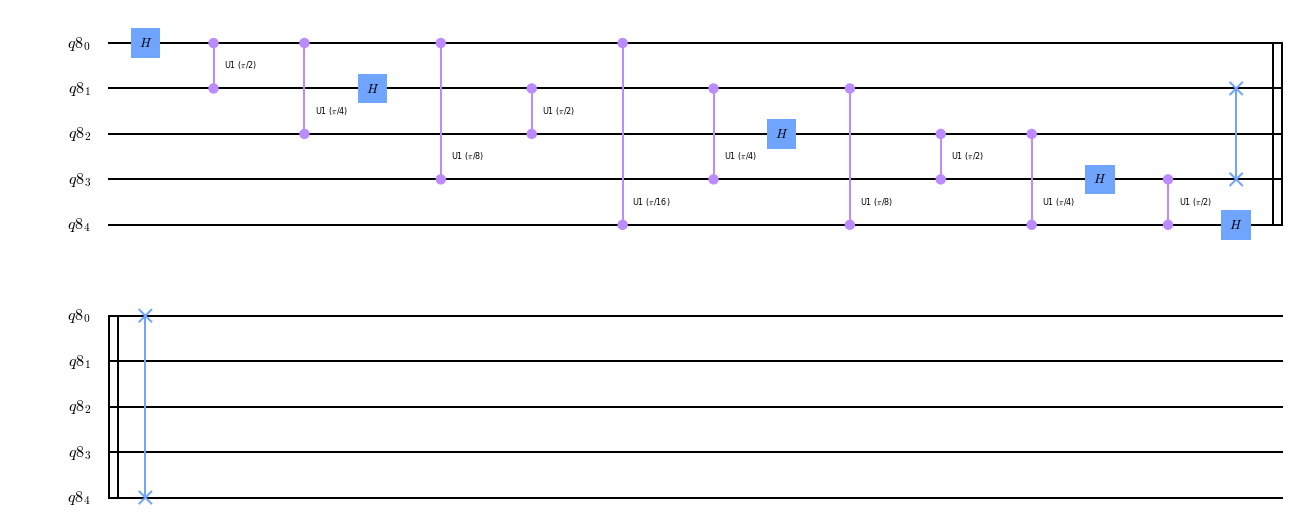

In [38]:
q = qiskit.circuit.library.QFT(5)
q.draw('mpl')

In [34]:
n = 3
qc = QuantumCircuit(n)
qftDagger = makeQFT(qc).to_gate().inverse()
qftDagger.name = 'QFT inverse'

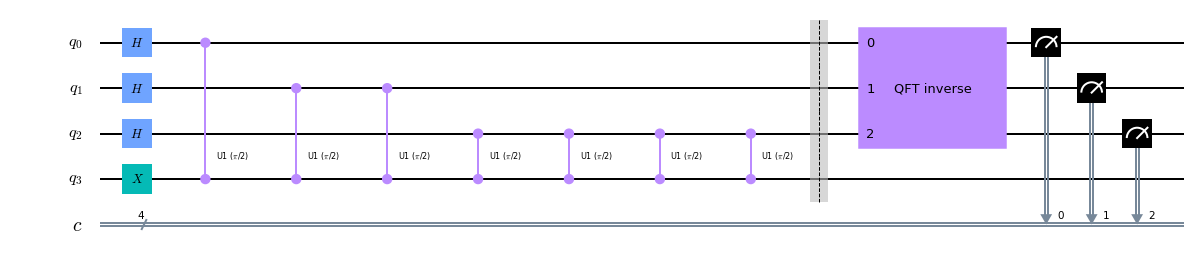

{'0010': 1}


In [9]:
qc = QuantumCircuit(4,4)
for i in range(3):
    qc.h(i)
qc.x(3)
qc.cu1(np.pi/2, 0, 3)
qc.cu1(np.pi/2, 1, 3)
qc.cu1(np.pi/2, 1, 3)
qc.cu1(np.pi/2, 2, 3)
qc.cu1(np.pi/2, 2, 3)
qc.cu1(np.pi/2, 2, 3)
qc.cu1(np.pi/2, 2, 3)
qc.barrier()
# qc.swap(0,2)
qc.append(qftDagger, range(3))
for i in range(3):
    qc.measure(i, i)
display(qc.draw('mpl'))
sim = Aer.get_backend('qasm_simulator')
result = execute(qc, sim, shots = 1).result()
print(result.get_counts(qc))

In [10]:
def QPE(circuit, gate, unknown_state_qubits, ancillia_qubits):
    unknown_state_qubits = list(unknown_state_qubits)
    ancillia_qubits = list(ancillia_qubits)
    t = len(ancillia_qubits)
    for i in range(t):
        temp = concatenate_gates(gate, int(math.pow(2, i)))
        controlled = temp.control(1)
        circuit.append(controlled, [ancillia_qubits[i], *unknown_state_qubits])
    return circuit
    
    
def concatenate_gates(gate, n):
    qc = QuantumCircuit(gate.num_qubits)
    for i in range(n):
        qc.append(gate, range(gate.num_qubits))
    gate_new = qc.to_gate()
    gate_new.name = gate.name+'x'+str(n)
    return gate_new

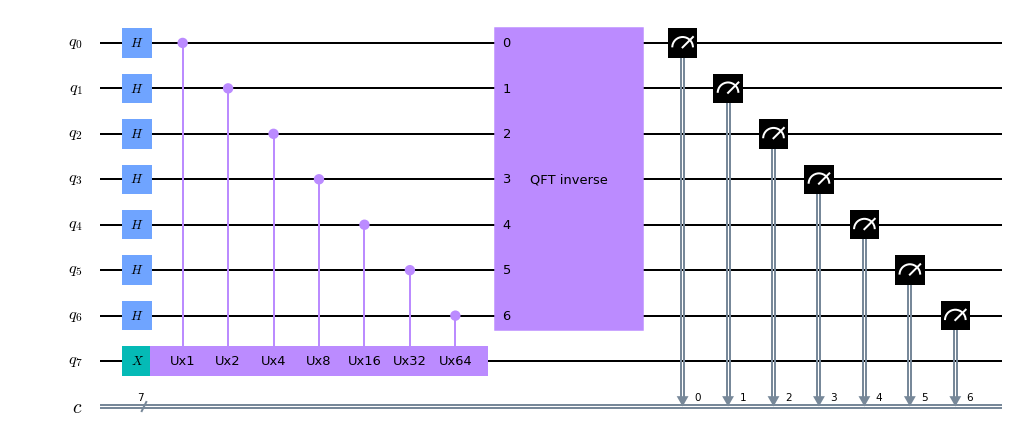

{'0011010': 1}


In [11]:
gate = QuantumCircuit(1)
gate.u1(np.pi/3, 0)
gate = gate.to_gate()
gate.name = 'U'

t = 7

initial_state = '10'
########################################################################################
ancillia_qubits = list(range(t))
unknown_gate_qubits = list(range(t, t+gate.num_qubits))

qc = QuantumCircuit(len(ancillia_qubits)+len(unknown_gate_qubits), len(ancillia_qubits))

init(list(reversed(unknown_gate_qubits)), initial_state, qc)

for i in ancillia_qubits:
    qc.h(i)

qc = QPE(qc, gate, unknown_gate_qubits, ancillia_qubits)

qftDagger = QuantumCircuit(len(ancillia_qubits))
qftDagger = makeQFT(qftDagger).to_gate().inverse()
qftDagger.name = 'QFT inverse'
qc.append(qftDagger, ancillia_qubits)

for i in ancillia_qubits:
    qc.measure(i, i)

display(qc.draw('mpl'))
sim = Aer.get_backend('qasm_simulator')
result = execute(qc, sim, shots = 1).result()
print(result.get_counts(qc))

In [12]:
qc_gate = QuantumCircuit(1)
qc_gate.x(0)
gate = qc_gate.to_gate()
gate.name = 'X'
# qc1 = QuantumCircuit(1)
# qc1.append(gate, [0])
# display(qc1.draw('mpl'))
# gate.to_matrix()
# h = qc.to_gate()
# qc.append(h, [0])
# display(qc.draw())
h2 = concatenate_gates(gate, 4)
qc = QuantumCircuit(1,1)
qc.append(h2, [0])
# qc.h(0)
qc.measure(0,0)
qc.draw('mpl')
# print(h2.num_qubits)
# print(h2.to_matrix())
sim = Aer.get_backend('qasm_simulator')
# display(qc.draw())
result = execute(qc, sim, shots= 1).result()
print(result.get_counts(qc))


{'0': 1}


In [51]:
a = set()
a.add('a')
a.add(1)
print(a)

{1, 'a'}


In [53]:
a = [1,2,3,4,5]
b = a%2
print(b)

TypeError: unsupported operand type(s) for %: 'list' and 'int'